In [147]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
n_rep = 100
n_bins = 1000
n_nodes = 10
n_regions = 40
n_reads = 10000
PATH = '../../workflows/bp_detection_performance/results/'

In [4]:
gt_files = [PATH + str(n_nodes)+'nodes_'+str(n_regions)+'regions_'+str(n_reads) \
             +'reads_simdata_'+str(x)+'_effective_regions.txt' for x in range(0,n_rep)]
bps_files = [PATH + 'simdata_'+str(x)+'_all_bps_comparison.csv' for x in range(0,n_rep)]
all_bins = range(0,n_bins)

In [5]:
all_bins

range(0, 1000)

In [87]:
all_tpr = []
all_fpr = []
all_bps_tables = []
for gt_file, bps_file in tqdm(zip(gt_files, bps_files)):
    bps = pd.read_csv(bps_file, header=None)
    bps.columns = ['idx','log_sp','stdev']
    bps['ranking'] = bps['log_sp'] / bps['stdev']
    # bps = bps.sort_values('ranking',ascending=False)
    bps = bps.dropna()
    
    all_bps_tables.append(bps)
    
    ground_truth = pd.read_csv(gt_file,header=None)
    ground_truth = ground_truth[0].values.tolist()
    threshold_coeffs = sorted(bps['ranking'].values)
    # Each breakpoint candidate has a different stdev value.
    # The ROC computations takes that into account.tpr_values = []
    tpr_values = []
    fpr_values = []
    for thr in threshold_coeffs:
        predicted_positives = []
        predicted_negatives = []
        for index, row in bps.iterrows():
            if row['ranking'] > thr:
                predicted_positives.append(row['idx'])
            else:
                break 
                
        #import ipdb; ipdb.set_trace()
        predicted_negatives = [i for i in all_bins if i not in predicted_positives]

        true_positives = [i for i in predicted_positives if i in ground_truth]
        false_positives = [i for i in predicted_positives if i not in ground_truth]

        true_negatives = [i for i in predicted_negatives if i not in ground_truth]
        false_negatives = [i for i in predicted_negatives if i in ground_truth]

        # import ipdb; ipdb.set_trace()
        assert(len(ground_truth) == (len(true_positives) + len(false_negatives)))
        tpr = len(true_positives) / len(ground_truth) # len(ground_truth)
        fpr = len(false_positives) / (1000 - len(ground_truth)) # (len(false_positives) + len(true_negatives))
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    
    all_tpr.append(tpr_values)
    all_fpr.append(fpr_values)

A Jupyter Widget

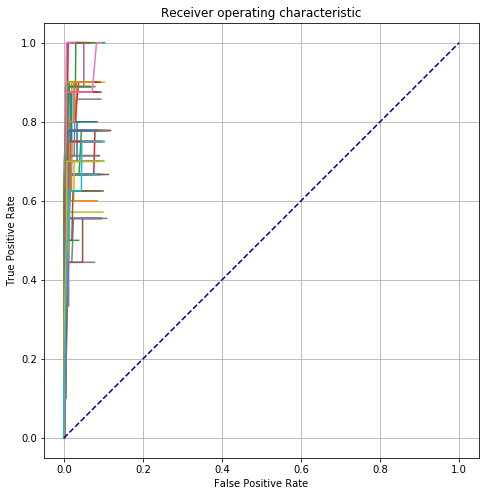

In [9]:
auc_vals = []
plt.figure(figsize=(8,8))
for tpr_values, fpr_values in zip(all_tpr, all_fpr):
    roc_auc = auc(fpr_values, tpr_values)
    auc_vals.append(roc_auc)
    plt.plot(fpr_values, tpr_values) # label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
plt.show()

In [10]:
pd.DataFrame(auc_vals, columns=['AUC']).describe()

,AUC
count,100.000000
mean,0.057471
std,0.016147
min,0.015808
25%,0.046684
50%,0.059670
75%,0.067477
max,0.096367


In [84]:
threshold_indices = []
for idx, val in enumerate(all_tpr):
    df = pd.DataFrame(data=[all_tpr[idx],all_fpr[idx]]).T
    df.columns = ['tpr','fpr']
    df['idx'] = df.index
    df = df[df['tpr']==df['tpr'].max()]
    df = df[df['fpr']==df['fpr'].min()]
    print(df)
    thr_idx = df.idx.values[0]
    threshold_indices.append(thr_idx)

    tpr       fpr  idx
71  0.7  0.009091   71
    tpr       fpr  idx
69  0.9  0.020202   69
         tpr       fpr  idx
83  0.666667  0.014127   83
     tpr       fpr  idx
84  0.75  0.004032   84
85  0.75  0.004032   85
         tpr       fpr  idx
15  0.666667  0.018163   15
         tpr       fpr  idx
56  0.888889  0.006054   56
      tpr       fpr  idx
36  0.625  0.011089   36
    tpr       fpr  idx
40  1.0  0.008073   40
         tpr       fpr  idx
90  0.555556  0.006054   90
         tpr       fpr  idx
80  0.777778  0.012109   80
         tpr       fpr  idx
82  0.666667  0.009082   82
      tpr       fpr  idx
68  0.875  0.017137   68
         tpr       fpr  idx
56  0.888889  0.010091   56
         tpr       fpr  idx
45  0.777778  0.017154   45
         tpr       fpr  idx
42  0.666667  0.013118   42
    tpr       fpr  idx
82  0.7  0.014141   82
         tpr       fpr  idx
89  0.555556  0.002018   89
    tpr       fpr  idx
35  1.0  0.009082   35
     tpr       fpr  idx
80  0.75  0.01

In [119]:
len(threshold_indices)

100

In [96]:
len(all_tpr[0])

88

In [92]:
all_bps_tables[0].shape

(88, 4)

In [97]:
all_bps_tables[0]

,idx,log_sp,stdev,ranking
0,496,4.092890,0.401566,10.192322
1,736,3.451100,0.344237,10.025360
2,686,2.859260,0.287063,9.960392
3,474,2.723300,0.246819,11.033591
4,317,2.062900,0.196950,10.474232
5,298,1.872040,0.157610,11.877673
6,603,1.023930,0.127234,8.047613
7,200,1.003070,0.112884,8.885847
8,244,0.827593,0.095826,8.636369
9,682,0.659478,0.082399,8.003432


In [100]:
threshold_indices

[71,
 69,
 83,
 84,
 15,
 56,
 36,
 40,
 90,
 80,
 82,
 68,
 56,
 45,
 42,
 82,
 89,
 35,
 80,
 74,
 50,
 64,
 94,
 9,
 87,
 63,
 43,
 81,
 82,
 45,
 101,
 71,
 24,
 57,
 73,
 102,
 67,
 79,
 42,
 86,
 52,
 90,
 26,
 37,
 33,
 80,
 77,
 71,
 95,
 46,
 74,
 90,
 68,
 64,
 103,
 76,
 70,
 68,
 77,
 58,
 7,
 17,
 81,
 52,
 93,
 99,
 75,
 98,
 85,
 76,
 68,
 68,
 70,
 72,
 1,
 44,
 48,
 64,
 66,
 91,
 65,
 49,
 83,
 76,
 80,
 55,
 21,
 48,
 31,
 63,
 72,
 75,
 54,
 83,
 60,
 75,
 13,
 74,
 93,
 57]

In [105]:
bps_thresholds = []
for idx, val in enumerate(threshold_indices):
    bps_thresholds.append(all_bps_tables[idx].iloc[[val]]['ranking'].values[0])

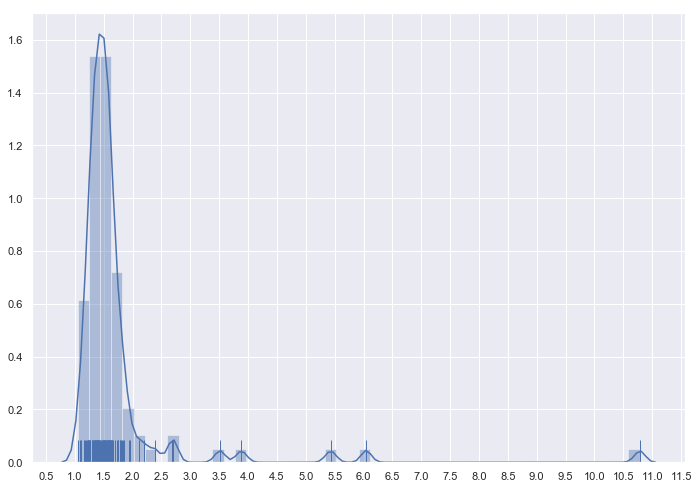

In [152]:
ax = sns.distplot(bps_thresholds, rug=True);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))